### Setups and Imports

In [1]:
import pandas as pd
import string
import pickle
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup


# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

### Exploratory Data Analysis

In [62]:
reviews_all = pd.read_csv("./data/fake reviews dataset.csv")
reviews_all.shape

(40432, 4)

In [63]:
# check for missing data
reviews_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [64]:
reviews_all.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [65]:
reviews_all['text_length'] = reviews_all['text_'].apply(len)
reviews_all.head(2)

,category,rating,label,text_,text_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",75
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",80


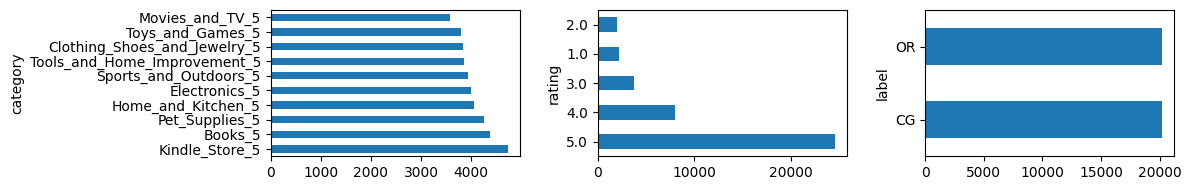

In [66]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12,2)

reviews_all['category'].value_counts().plot(kind='barh', ax=axes[0])
reviews_all['rating'].value_counts().plot(kind='barh', ax=axes[1])
reviews_all['label'].value_counts().plot(kind='barh', ax=axes[2])
plt.tight_layout()

Text(0.5, 0, 'Review Length (characters)')

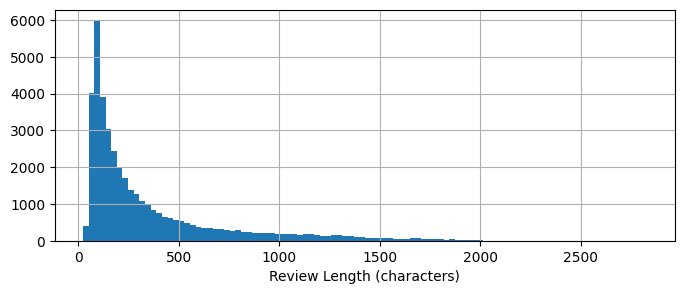

In [67]:
reviews_all['text_length'].hist(bins=100, figsize=(8,3))
plt.xlabel("Review Length (characters)")

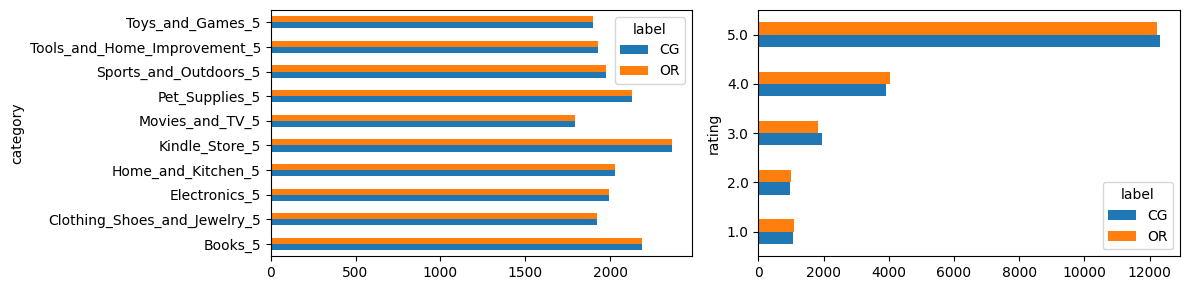

In [68]:
# distribution of CG labels in all categories

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12,3)

val_counts = reviews_all[['label', 'category']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='category', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, ax=axes[0])

val_counts = reviews_all[['label', 'rating']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='rating', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, ax=axes[1])

plt.tight_layout()

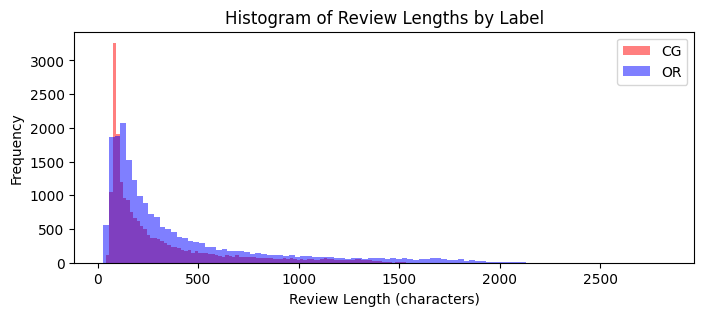

In [69]:
label_CG = reviews_all[reviews_all['label'] == 'CG']['text_length']
label_OR = reviews_all[reviews_all['label'] == 'OR']['text_length']

plt.figure(figsize=(8, 3))

# Plot histogram for label 'CG'
plt.hist(label_CG, bins=100, alpha=0.5, label='CG', color='red')

# Plot histogram for label 'OR'
plt.hist(label_OR, bins=100, alpha=0.5, label='OR', color='blue')

plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.title("Histogram of Review Lengths by Label")
plt.legend()

plt.show()

### Text Exploration

In [70]:
reviews_all.describe()

,rating,text_length
count,40432.000000,40432.000000
mean,4.256579,351.271963
std,1.144354,369.813570
min,1.000000,24.000000
25%,4.000000,107.000000
50%,5.000000,198.000000
75%,5.000000,439.000000
max,5.000000,2827.000000


In [71]:
# long review texts
reviews_all[reviews_all.text_length>250].head()

,category,rating,label,text_,text_length
1520,Home_and_Kitchen_5,5.0,OR,"<a data-hook=""product-link-linked"" class=""a-li...",347
2223,Home_and_Kitchen_5,5.0,OR,"Once you get used to the settings, it makes de...",254
2290,Home_and_Kitchen_5,1.0,OR,This thermostat worked great at first but soon...,261
2333,Home_and_Kitchen_5,5.0,OR,This is a solid piece of gear. I ordered it af...,253
2353,Home_and_Kitchen_5,5.0,OR,I love my Vellux Blanket and have had them in ...,253


In [72]:
# sample long review
print(reviews_all.loc[1520]['text_'])

<a data-hook="product-link-linked" class="a-link-normal" href="/ORBLUE-Flatware-Pie-Server-Stainless-Steel-Cake-Cutter/dp/B011J5MKPC/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">ORBLUE Flatware Pie Server Stainless Steel Cake Cutter</a>&nbsp;FOR REVIEW

GREAT QUALITY. nice finish good and solid item feels and looks very professional. well worth the purchase


In [73]:
# sample long review
print(reviews_all.loc[2223]['text_'])

Once you get used to the settings, it makes deliciously, moist meats!!
We seared our meat for just a couple minutes after cooking. It is a great kitchen addition and would highly recommend!
We put the seasoned meats in one sealed bag, veggies in another.


In [74]:
# function to detect URLs in the text field

def detect_urls(text):
    # Regular expression to detect URLs
    url_pattern = re.compile(r'(https?://\S+|www\.\S+)')
    
    # Find all URLs using the pattern
    urls = url_pattern.findall(text)
    
    return urls

# Example usage
sample_text = "Check out the documentation at https://www.nltk.org/ and also visit http://example.com for more details. Also, www.test.com is a good resource."

detected_urls = detect_urls(sample_text)
print("Detected URLs:", detected_urls)

Detected URLs: ['https://www.nltk.org/', 'http://example.com', 'www.test.com']


In [75]:
reviews_all_tmp = reviews_all.copy()

reviews_all_tmp['URLs'] = reviews_all_tmp['text_'].apply(detect_urls)

reviews_all_tmp = reviews_all_tmp[reviews_all_tmp['URLs'].apply(lambda x: len(x) > 0)]
print("Rows with URLs in reviews : ", reviews_all_tmp.shape[0])
reviews_all_tmp.head(3)

Rows with URLs in reviews :  108


,category,rating,label,text_,text_length,URLs
633,Home_and_Kitchen_5,4.0,OR,I love this product. I also recommend this:htt...,93,[http://goo.]
1386,Home_and_Kitchen_5,4.0,OR,Exactly as described! This mat fit our 16x16 a...,247,[http://www.amazon.com/gp/product/B0049OAQ48/r...
1395,Home_and_Kitchen_5,4.0,OR,"These are nice, but not as good as the York de...",207,[http://www.amazon.com/gp/product/B004KKXA6C/r...


In [76]:
# review text with URLs
print(reviews_all.loc[1386]['text_'])

Exactly as described! This mat fit our 16x16 artwork perfectly and works wonderfully with this frame:

http://www.amazon.com/gp/product/B0049OAQ48/ref=cm_cr_ryp_prd_ttl_sol_8

Together, both of these products saved us hundreds over custom framing!


### Preprocessing | Text Cleaning

In [77]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_review(text):

    # Regular expression to detect URLs
    url_pattern = re.compile(r'(https?://\S+|www\.\S+)')

    # Replace URLs with 'URL' word
    text = url_pattern.sub('URL', text)

    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and punctuation using regular expressions
    re_punctuations = re.compile('[%s]'%re.escape(string.punctuation))
    text = re_punctuations.sub(' ', text)

    # Remove numbers
    text = re.sub(r'[\d+]', '', text)

    # Replace multiple spaces with one single space
    text = re.sub(r'\s+', ' ', text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stopwords and perform lemmatization
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a single string
    return ' '.join(cleaned_text)

In [78]:
sample_review = reviews_all.loc[1520]['text_']
cleaned_review = clean_review(sample_review)

print("Original Review text : ", sample_review)
print("\n\nCleaned Review : ", cleaned_review)

Original Review text :  <a data-hook="product-link-linked" class="a-link-normal" href="/ORBLUE-Flatware-Pie-Server-Stainless-Steel-Cake-Cutter/dp/B011J5MKPC/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">ORBLUE Flatware Pie Server Stainless Steel Cake Cutter</a>&nbsp;FOR REVIEW

GREAT QUALITY. nice finish good and solid item feels and looks very professional. well worth the purchase


Cleaned Review :  orblue flatware pie server stainless steel cake cutter review great quality nice finish good solid item feel look professional well worth purchase


In [79]:
sample_review = reviews_all.loc[2223]['text_']
cleaned_review = clean_review(sample_review)

print("Original Review text : ", sample_review)
print("\n\nCleaned Review : ", cleaned_review)

Original Review text :  Once you get used to the settings, it makes deliciously, moist meats!!
We seared our meat for just a couple minutes after cooking. It is a great kitchen addition and would highly recommend!
We put the seasoned meats in one sealed bag, veggies in another.


Cleaned Review :  get used setting make deliciously moist meat seared meat couple minute cooking great kitchen addition would highly recommend put seasoned meat one sealed bag veggie another


In [80]:
sample_review = reviews_all.loc[1386]['text_']
cleaned_review = clean_review(sample_review)

print("Original Review text : ", sample_review)
print("\n\nCleaned Review : ", cleaned_review)

Original Review text :  Exactly as described! This mat fit our 16x16 artwork perfectly and works wonderfully with this frame:

http://www.amazon.com/gp/product/B0049OAQ48/ref=cm_cr_ryp_prd_ttl_sol_8

Together, both of these products saved us hundreds over custom framing!


Cleaned Review :  exactly described mat fit x artwork perfectly work wonderfully frame url together product saved u hundred custom framing


In [81]:
reviews_all['cleaned_text'] = reviews_all['text_'].apply(clean_review)
reviews_all['cleantext_length'] = reviews_all['cleaned_text'].apply(len)

C:\Users\Shashank Prakash\AppData\Local\Temp\ipykernel_18632\4189046691.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


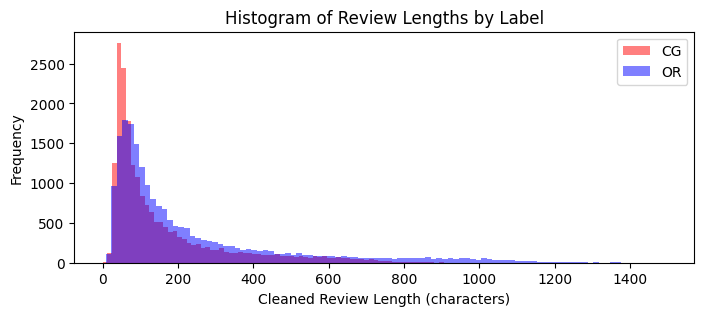

In [82]:
label_CG = reviews_all[reviews_all['label'] == 'CG']['cleantext_length']
label_OR = reviews_all[reviews_all['label'] == 'OR']['cleantext_length']

plt.figure(figsize=(8, 3))

# Plot histogram for label 'CG'
plt.hist(label_CG, bins=100, alpha=0.5, label='CG', color='red')

# Plot histogram for label 'OR'
plt.hist(label_OR, bins=100, alpha=0.5, label='OR', color='blue')

plt.xlabel("Cleaned Review Length (characters)")
plt.ylabel("Frequency")
plt.title("Histogram of Review Lengths by Label")
plt.legend()

plt.show()

In [83]:
reviews_all.describe()

,rating,text_length,cleantext_length
count,40432.000000,40432.000000,40432.00000
mean,4.256579,351.271963,197.86617
std,1.144354,369.813570,213.65056
min,1.000000,24.000000,0.00000
25%,4.000000,107.000000,61.00000
50%,5.000000,198.000000,111.00000
75%,5.000000,439.000000,243.00000
max,5.000000,2827.000000,1496.00000


In [84]:
# long cleaned review texts
reviews_all[reviews_all.cleantext_length>250].head()

,category,rating,label,text_,text_length,cleaned_text,cleantext_length
2880,Home_and_Kitchen_5,1.0,OR,"""Leakproof?"" Not hardly! Ever had stewed chees...",441,leakproof hardly ever stewed cheesecake one tw...,285
2917,Home_and_Kitchen_5,5.0,OR,Okay... let me start by saying that I have nev...,375,okay let start saying never used apple corer a...,253
2930,Home_and_Kitchen_5,5.0,OR,"Great item, I purchased this to add to my coll...",404,great item purchased add collection heart shap...,273
2946,Home_and_Kitchen_5,5.0,OR,I already have a full blown carpet steamer (Ho...,411,already full blown carpet steamer hoover brand...,255
2947,Home_and_Kitchen_5,5.0,OR,This hand blender works great. Easy cleanup a...,420,hand blender work great easy cleanup easy stor...,287


In [85]:
# long cleaned review texts
print("Original Text : ", reviews_all.loc[2880]['text_'])
print("\n\nCleaned Text : ", reviews_all.loc[2880]['cleaned_text'])

Original Text :  "Leakproof?" Not hardly! Ever had stewed cheesecake? That's what one of the two of these I purchased and used today for the first time produced. When I unhooked the clasp, water leaked out. and the entire bottom inch of my little cheesecake is soggy. Despite their pricey-ness, these things are made in China. They're going back to Amazon--which, thank you Jeff--stands behind every product they sell. (I'd recommend ditching this one, Jeff.


Cleaned Text :  leakproof hardly ever stewed cheesecake one two purchased used today first time produced unhooked clasp water leaked entire bottom inch little cheesecake soggy despite pricey ness thing made china going back amazon thank jeff stand behind every product sell recommend ditching one jeff


In [86]:
reviews_all.to_pickle("./data/processed_reviews_v1.pkl")

### Train Test Validation Data Split

In [15]:
# both train, val and test split should have even representation across all the ratings

reviews_data = pd.read_pickle("./data/processed_reviews_v1.pkl")

splitter =StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=72)

for train_index, test_index in splitter.split(reviews_data, reviews_data['rating']):
    reviews_train = reviews_data.iloc[train_index]
    reviews_test_tmp = reviews_data.iloc[test_index]

val_splitter =StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=72)

for test_index, val_index in val_splitter.split(reviews_test_tmp, reviews_test_tmp['rating']):
    reviews_test = reviews_test_tmp.iloc[test_index]
    reviews_val = reviews_test_tmp.iloc[val_index]

reviews_data.shape, reviews_train.shape, reviews_test.shape, reviews_val.shape

((40432, 7), (32345, 7), (7076, 7), (1011, 7))

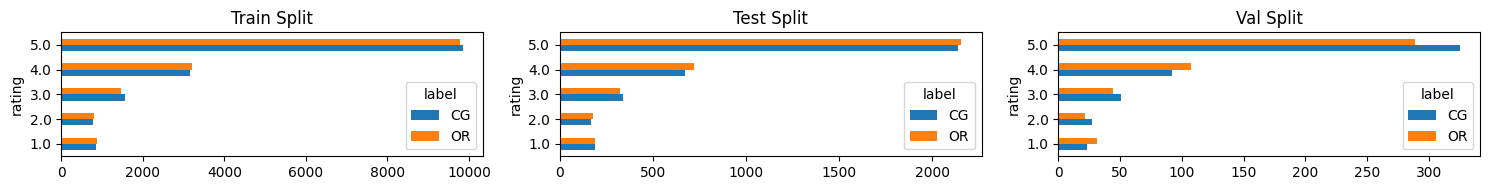

In [21]:
# distribution of CG labels in train-test-val splits

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15,2)

val_counts = reviews_train[['label', 'rating']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='rating', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, ax=axes[0], title='Train Split')

val_counts = reviews_test[['label', 'rating']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='rating', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, ax=axes[1], title='Test Split')

val_counts = reviews_val[['label', 'rating']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='rating', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, ax=axes[2], title='Val Split')

plt.tight_layout()

In [22]:
reviews_train.to_pickle("./data/processed_reviews_train_v1.pkl")
reviews_test.to_pickle("./data/processed_reviews_test_v1.pkl")
reviews_val.to_pickle("./data/processed_reviews_val_v1.pkl")

### Preprocessing | TF-IDF Features

In [34]:
reviews_train = pd.read_pickle("./data/processed_reviews_train_v1.pkl")
reviews_data.head()

,category,rating,label,text_,text_length,cleaned_text,cleantext_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",75,love well made sturdy comfortable love pretty,45
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",80,love great upgrade original mine couple year,44
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,67,pillow saved back love look feel pillow,39
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",81,missing information use great product price,43
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,85,nice set good quality set two month,35


In [4]:
def get_tfidf_vectorizer(df_in, text_col,  minperc=0.005, maxperc=0.995):

    '''
    Fits a TF-IDF vectorizer on the specified text column and returns the vectorizer.
    Considers words with occurence percentage in the range [minperc, maxperc]
    '''

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(min_df=minperc, max_df=maxperc)
    vectorizer.fit(df_in[text_col])

    return vectorizer



def get_tfidf_features(df_in, text_col, vectorizer):

    '''
    Returns dataframe with tf-idf features created from the 'text_col'
    using the provided vectorizer.
    '''

    # Use the passed vectorizer to transform the text column
    X = vectorizer.transform(df_in[text_col])

    # Convert the sparse matrix to a DataFrame
    col_names = ["f_" + wordcol for wordcol in vectorizer.get_feature_names_out()]
    tfidf_df = pd.DataFrame(X.toarray(), columns=col_names, index=df_in.index)

    # Merge the TF-IDF features with the original DataFrame using the index
    df_out = df_in.merge(tfidf_df, left_index=True, right_index=True)

    return df_out

In [46]:
tfidf_vect = get_tfidf_vectorizer(reviews_train, 'cleaned_text')

# Save the fitted TfidfVectorizer object as pickle file
with open('./artifacts/eda/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vect, f)

# Load the vectorizer from the pickle file
with open('./artifacts/eda/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vect_v2 = pickle.load(f)

In [47]:
reviews_train_wt_tfidf = get_tfidf_features(reviews_train, 'cleaned_text', tfidf_vect_v2)
reviews_test_wt_tfidf = get_tfidf_features(reviews_test, 'cleaned_text', tfidf_vect_v2)
reviews_val_wt_tfidf = get_tfidf_features(reviews_val, 'cleaned_text', tfidf_vect_v2)

reviews_train_wt_tfidf.to_pickle("./data/processed_reviews_train_v2.pkl")
reviews_test_wt_tfidf.to_pickle("./data/processed_reviews_test_v2.pkl")
reviews_val_wt_tfidf.to_pickle("./data/processed_reviews_val_v2.pkl")

### Preprocessing | Standardization

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

### Baseline | SGD Classifier

In [5]:
# prepare data for model

def get_xydata(file_path, file_name, col_text, vectorizer, cols_x, col_y, col_y_mapper):

    '''
    Input Parameters:
     Imports the file 'file_name' from location 'file_path' which has the column 'col_text'.
     Numerical features will be created on this text column which will be required for model training/evaluation.
     'vectorizer' : pickle file with tf-idf vectorizer.
     'cols_x' : list of independent features from the file 'file_name' required in 'df_x'.
     'col_y' : list with a single target column. Its mandatory to have 'CG' in this column for computer generated reviews.
     'col_y_mapper' : dictionary to map text contents of 'col_y' to integers.
    Outputs:
     'df_x' and 'df_y': numpy nd-arrays which contain the independent features and target variable respectively.
     'cols_x' and 'cols_y' : lists containing column names corresponding to the columns of output matrices.
     
    '''

    # Read the input file
    dframe = pd.read_pickle(file_path + file_name)

    assert all([col in dframe.columns for col in cols_x + col_y + [col_text]]), "required column(s) from input parameters not found"

    # Load the vectorizer from the pickle file
    with open(vectorizer, 'rb') as f:
        tfidf_vect = pickle.load(f)
    tfidf_features = ["f_" + wordcol for wordcol in tfidf_vect.get_feature_names_out()]

    # Create tf-idf features
    dframe_tfidf = get_tfidf_features(dframe, col_text, tfidf_vect)

    df_x = dframe_tfidf[tfidf_features + cols_x].copy()
    df_y = dframe_tfidf[col_y].copy()
    # df_y[col_y[0]] = df_y[col_y[0]].apply(lambda x : 1 if x=='CG' else 0)
    df_y[col_y[0]] = df_y[col_y[0]].map(col_y_mapper)

    return df_x.values, df_y.values.flatten(), list(df_x.columns), list(df_y.columns)

In [6]:
cols_x = ['rating']
col_y = ['label']
col_y_mapper = {'CG':1, 'OR':0}
file_path = "./data/"
col_text = 'cleaned_text'
vectorizer_file = './artifacts/eda/tfidf_vectorizer.pkl'

train_x, train_y, train_xcols, train_ycols = get_xydata(file_path, "processed_reviews_train_v1.pkl", col_text, vectorizer_file, cols_x, col_y, col_y_mapper)
test_x, test_y, test_xcols, test_ycols = get_xydata(file_path, "processed_reviews_test_v1.pkl", col_text, vectorizer_file, cols_x, col_y, col_y_mapper)

In [29]:
# train sgd classifier
baseline_sgd = SGDClassifier(max_iter=1000, tol=1e-3, loss='modified_huber', random_state=72)
baseline_sgd.fit(train_x, train_y)

# save the model as pickle file
with open('./artifacts/eda/baseline_sgd.pkl', 'wb') as f:
    pickle.dump(baseline_sgd, f)

Sample Prediction, test row 0 :  [1]
Actual Label, test row 0 :  1
Accuracy on 3 folds :  [0.82220367 0.76803932 0.81161302]
Accuracy on test data :  0.824335782928208
Confusion Matrix :


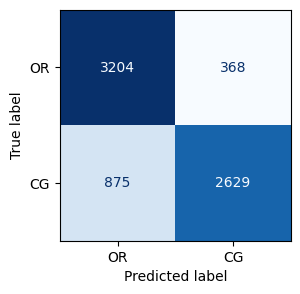

In [30]:
# Load the model from the pickle file
with open('./artifacts/eda/baseline_sgd.pkl', 'rb') as f:
    baseline_sgd_clf = pickle.load(f)

# predict on smaple row
print("Sample Prediction, test row 0 : ", baseline_sgd_clf.predict(test_x[0].reshape(1,-1)))
print("Actual Label, test row 0 : ", test_y[0])

# accuracy of the model

print("Accuracy on 3 folds : ", cross_val_score(baseline_sgd_clf, train_x, train_y, cv=3, scoring="accuracy"))

test_y_preds_sgd = baseline_sgd_clf.predict(test_x)
print("Accuracy on test data : ", accuracy_score(test_y, test_y_preds_sgd))

# confusion matrix of the model predictions on test data

print("Confusion Matrix :")

# Sort the dictionary by its values and extract the keys
sorted_keys = [key for key, value in sorted(col_y_mapper.items(), key=lambda item: item[1])]

conf_mx = confusion_matrix(test_y, test_y_preds_sgd)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=sorted_keys)

fig, ax = plt.subplots(figsize=(3,3))
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.show()

### Baseline | Logistic Regression

In [211]:
# train logistic classifier
baseline_log = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)
baseline_log.fit(train_x, train_y)

# save the model as pickle file
with open('./artifacts/eda/baseline_log.pkl', 'wb') as f:
    pickle.dump(baseline_log, f)

Sample Prediction, test row 0 :  [1]
Actual Label, test row 0 :  1
Accuracy on 3 folds :  [0.82591356 0.83045817 0.82645395]
Accuracy on test data :  0.8309779536461278
Confusion Matrix :


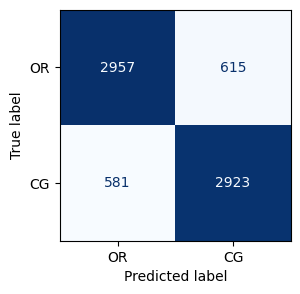

In [212]:
# Load the model from the pickle file
with open('./artifacts/eda/baseline_log.pkl', 'rb') as f:
    baseline_log_clf = pickle.load(f)

# predict on smaple row
print("Sample Prediction, test row 0 : ", baseline_log_clf.predict(test_x[0].reshape(1,-1)))
print("Actual Label, test row 0 : ", test_y[0])

# accuracy of the model

print("Accuracy on 3 folds : ", cross_val_score(baseline_log_clf, train_x, train_y, cv=3, scoring="accuracy"))

test_y_preds_log = baseline_log_clf.predict(test_x)
print("Accuracy on test data : ", accuracy_score(test_y, test_y_preds_log))

# confusion matrix of the model predictions on test data

print("Confusion Matrix :")

# Sort the dictionary by its values and extract the keys
sorted_keys = [key for key, value in sorted(col_y_mapper.items(), key=lambda item: item[1])]

conf_mx = confusion_matrix(test_y, test_y_preds_log)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=sorted_keys)

fig, ax = plt.subplots(figsize=(3,3))
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.show()

### Baseline | Tree Based Classification

In [10]:
# train logistic classifier
baseline_rf = RandomForestClassifier(n_estimators=200, min_samples_split=0.02, random_state=72)
baseline_rf.fit(train_x, train_y)

# save the model as pickle file
with open('./artifacts/eda/baseline_rf.pkl', 'wb') as f:
    pickle.dump(baseline_rf, f)

Sample Prediction, test row 0 :  [1]
Actual Label, test row 0 :  1
Accuracy on 3 folds :  [0.8016138  0.80356149 0.80261571]
Accuracy on test data :  0.8092142453363482
Confusion Matrix :


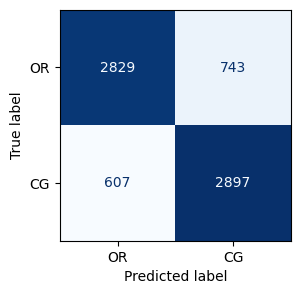

In [11]:
# Load the model from the pickle file
with open('./artifacts/eda/baseline_rf.pkl', 'rb') as f:
    baseline_rf_clf = pickle.load(f)

# predict on smaple row
print("Sample Prediction, test row 0 : ", baseline_rf_clf.predict(test_x[0].reshape(1,-1)))
print("Actual Label, test row 0 : ", test_y[0])

# accuracy of the model

print("Accuracy on 3 folds : ", cross_val_score(baseline_rf_clf, train_x, train_y, cv=3, scoring="accuracy"))

test_y_preds_rf = baseline_rf_clf.predict(test_x)
print("Accuracy on test data : ", accuracy_score(test_y, test_y_preds_rf))

# confusion matrix of the model predictions on test data

print("Confusion Matrix :")

# Sort the dictionary by its values and extract the keys
sorted_keys = [key for key, value in sorted(col_y_mapper.items(), key=lambda item: item[1])]

conf_mx = confusion_matrix(test_y, test_y_preds_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=sorted_keys)

fig, ax = plt.subplots(figsize=(3,3))
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.show()

### Compare Baselines

In [68]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, ':', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')     # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

def get_roc(model_list, test_dfx, test_dfy):
    '''
    'model_list' : list of sklearn models
    'test_dfx' and 'test_dfy' : test features and targets
    Plots roc curves for the provided models and generates roc-auc scores based on 3 fold cv predictions.
    '''

    plt.figure(figsize=(10, 6))

    for sklmodel in model_list:
        # generate prediction probabilities for label=1('CG')
        test_y_preds = cross_val_predict(sklmodel, test_dfx, test_dfy, cv=3, method="predict_proba")[:,1]

        model_type = type(sklmodel).__name__
        fpr, tpr, _ = roc_curve(test_dfy, test_y_preds)
        plot_roc_curve(fpr, tpr, model_type)

        print(f"ROC Score for {model_type} : {roc_auc_score(test_dfy, test_y_preds):0.5f}")
    
    plt.legend(loc="lower right", fontsize=16)
    plt.title("ROC Comparison Plot")
    plt.show()

ROC Score for SGDClassifier : 0.87343
ROC Score for LogisticRegression : 0.89864
ROC Score for RandomForestClassifier : 0.87045


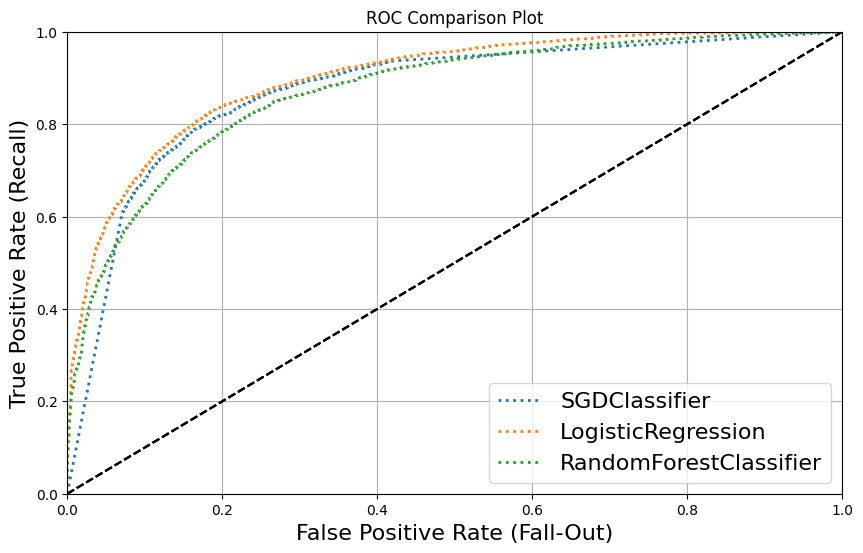

In [69]:
# Load the baseline model
with open('./artifacts/eda/baseline_sgd.pkl', 'rb') as f:
    baseline_sgd = pickle.load(f)
with open('./artifacts/eda/baseline_log.pkl', 'rb') as f:
    baseline_log = pickle.load(f)
with open('./artifacts/eda/baseline_rf.pkl', 'rb') as f:
    baseline_rf = pickle.load(f)

# generate roc scores and curves
model_list = [baseline_sgd, baseline_log, baseline_rf]
get_roc(model_list, test_x, test_y)